In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os


In [47]:
train_dir = "/content/drive/MyDrive/Teeth_Dataset/Training"
val_dir   = "/content/drive/MyDrive/Teeth_Dataset/Validation"
test_dir  = "/content/drive/MyDrive/Teeth_Dataset/Testing"


target_classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [48]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    classes=target_classes
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    classes=target_classes
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    classes=target_classes
)


Found 3116 images belonging to 7 classes.
Found 1044 images belonging to 7 classes.
Found 1036 images belonging to 7 classes.


In [37]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(target_classes), activation='softmax')
])


In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)


In [41]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 323ms/step - accuracy: 0.2111 - loss: 2.6361 - val_accuracy: 0.1427 - val_loss: 3.6452 - learning_rate: 1.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.3150 - loss: 1.7687 - val_accuracy: 0.1427 - val_loss: 6.4381 - learning_rate: 1.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy: 0.3812 - loss: 1.6103 - val_accuracy: 0.1427 - val_loss: 8.1917 - learning_rate: 1.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.4261 - loss: 1.5274
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.4261 - loss: 1.5275 - val_accuracy: 0.1657 - val_loss: 4.8877 - learning_rate: 1.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 38s 260ms/step - accuracy: 0.4245 - loss: 1.4952 - val_accuracy: 0.3113 - val_loss: 2.3642 - learning_rate: 3.0000e-05
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy

In [42]:
print("\n📊 Evaluation Results:")
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")

val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}% | Loss: {val_loss:.4f}")

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")



📊 Evaluation Results:
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.9017 - loss: 0.3205
Training Accuracy: 90.53% | Loss: 0.3195
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9059 - loss: 0.3435
Validation Accuracy: 90.52% | Loss: 0.3463
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9027 - loss: 0.3896 
Test Accuracy: 89.96% | Loss: 0.3548


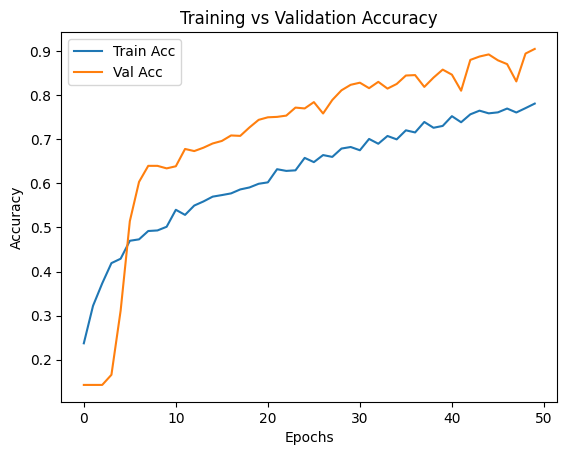

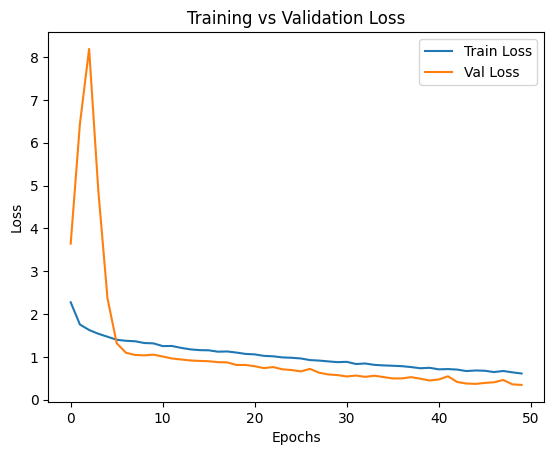

In [43]:
# 📈 Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 📉 Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [44]:
model.save("teeth_model.h5")
